In [3]:
from providers.generic_provider import GenericProvider
from database.chroma_db import ChromaDBManager
import tqdm
import uuid

/Users/lilianahotsko/Desktop/LLMAnonymizationThesis/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# read the texts from kaggle dataset 
https://www.kaggle.com/datasets/nbroad/wiki-20220301-en-sci

In [2]:
from datasets import load_dataset
from pathlib import Path

files = list(map(str, Path("test_data_rag").glob("*.parquet")))
ds = load_dataset("parquet", data_files=files, split="train")

/Users/lilianahotsko/Desktop/LLMAnonymizationThesis/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
len(ds["text"])

131049

In [4]:
df = ds.to_pandas()
df[:10]


,text,url,title
0,UV radiation resistance-associated gene protei...,https://en.wikipedia.org/wiki/UVRAG,UVRAG
1,Olfactory receptor 51E1 is a protein that in h...,https://en.wikipedia.org/wiki/OR51E1,OR51E1
2,Olfactory receptor 10AG1 is a protein that in ...,https://en.wikipedia.org/wiki/OR10AG1,OR10AG1
3,Olfactory receptor 14A16 is a protein that in ...,https://en.wikipedia.org/wiki/OR5AT1,OR5AT1
4,Olfactory receptor 10R2 is a protein that in h...,https://en.wikipedia.org/wiki/OR10R2,OR10R2
5,Olfactory receptor 1B1 is a protein that in hu...,https://en.wikipedia.org/wiki/OR1B1,OR1B1
6,Olfactory receptor 2A12 is a protein that in h...,https://en.wikipedia.org/wiki/OR2A12,OR2A12
7,This uniform polyhedron compound is a symmetri...,https://en.wikipedia.org/wiki/Compound%20of%20...,Compound of twelve pentagrammic crossed antipr...
8,Olfactory receptor 3A4 is a protein that in hu...,https://en.wikipedia.org/wiki/OR3A4,OR3A4
9,Olfactory receptor 2A5 is a protein that in hu...,https://en.wikipedia.org/wiki/OR2A5,OR2A5


----
# Retrieval with Chroma

In [4]:
# def store_from_folder_chroma(folder_name="uploaded_files", 
#                             collection_name="rag_collection",
#                             persist_path = "./test_data_rag_vectorstore2"):
#     chroma_db = ChromaDBManager(
#         collection_name=collection_name,
#         persist_path=persist_path,
#         chunk_size=300,
#         chunk_overlap=50,
#         model_name="all-MiniLM-L6-v2", 
#         reset=True
#     )
#     chroma_db.store_file(folder_name)

# def retrieve_from_chroma(query, 
#                         collection_name="rag_collection",
#                         persist_path = "./test_data_rag_vectorstore2"):
#     chroma_db = ChromaDBManager(
#         collection_name=collection_name,
#         persist_path=persist_path,
#         chunk_size=300,
#         chunk_overlap=50,
#         model_name="all-MiniLM-L6-v2", 
#         reset=False
#     )
#     retrieved_chunks = chroma_db.retrieve(query)
#     return retrieved_chunks

# def get_stored_chunks(collection_name="rag_collection",
#                         persist_path = "./test_data_rag_vectorstore2"):
#     chroma_db = ChromaDBManager(
#         collection_name=collection_name,
#         persist_path=persist_path,
#         chunk_size=300,
#         chunk_overlap=50,
#         model_name="all-MiniLM-L6-v2", 
#         reset=False
#     )
#     results = chroma_db.collection.get(include=["documents"])
#     stored_chunks = list(zip(results["documents"]))
#     return stored_chunks


In [2]:
persist_path = "./test_data_rag_vectorstore2"
collection_name = "rag_collection"

db = ChromaDBManager(
    collection_name=collection_name,
    persist_path=persist_path,
    chunk_size=300,
    chunk_overlap=50,
    model_name="all-MiniLM-L6-v2"
)

Existing collections: ['langchain', 'rag_collection']
Collection 'rag_collection' deleted.
Collection 'rag_collection' has been reset.


In [6]:
all_chunks = []

for i in tqdm.tqdm(range(0, 100)):
    text = ds["text"][i]
    title = ds["title"][i]
    url = ds["url"][i]
    chunks = db.splitter.split_text(text)
    embeddings = db._embed_texts(chunks)
    ids = [str(uuid.uuid4()) for _ in chunks]
    metadatas = [{"title": title, "url": url} for _ in chunks]
    db.collection.add(documents=chunks, embeddings=embeddings, ids=ids, metadatas=metadatas)


100%|██████████| 100/100 [01:08<00:00,  1.47it/s]


In [7]:
db.count_documents()

1147

In [8]:
results = db.collection.get(include=["documents", "metadatas"])
stored_chunks = list(zip(results["documents"], results["metadatas"]))


In [9]:
stored_chunks[:10]

[('UV radiation resistance-associated gene protein is a protein that in humans is encoded by the UVRAG gene.',
  {'title': 'UVRAG', 'url': 'https://en.wikipedia.org/wiki/UVRAG'}),
 ('This gene complements the ultraviolet sensitivity of xeroderma pigmentosum group C cells and encodes a protein with a C2 domain. The protein activates the Beclin1-PI(3)KC3 complex, promoting autophagy and suppressing the proliferation and tumorigenicity of human colon cancer cells.',
  {'title': 'UVRAG', 'url': 'https://en.wikipedia.org/wiki/UVRAG'}),
 ('Chromosomal aberrations involving this gene are associated with left-right axis malformation and mutations in this gene have been associated with colon cancer.\n\nReferences\n\nFurther reading',
  {'title': 'UVRAG', 'url': 'https://en.wikipedia.org/wiki/UVRAG'}),
 ('Olfactory receptor 51E1 is a protein that in humans is encoded by the OR51E1 gene.',
  {'title': 'OR51E1', 'url': 'https://en.wikipedia.org/wiki/OR51E1'}),
 ('Olfactory receptors interact with 

# Helper Functions

In [1]:
def build_question_prompt(chunk):
    return f"""
You are an AI assistant helping generate synthetic questions for a RAG dataset.

Given the context below, generate a clear and answerable question that could be answered using only this context.

Context:
\"\"\"
{chunk}
\"\"\"

Question:"""

async def generate_questions(stored_chunks, llm_question_generator, db):
    questions = []
    all_retrieved_chunks = []
    for chunk in stored_chunks:
        prompt = build_question_prompt(chunk)
        question = await llm_question_generator.invoke(prompt)
        questions.append(question.strip())
        retrieved_chunks = db.retrieve(question)
        all_retrieved_chunks.append(retrieved_chunks)
    return questions, all_retrieved_chunks


async def generate_question(chunk, llm_question_generator):
    prompt = build_question_prompt(chunk)
    question = await llm_question_generator.invoke(prompt)
    return question.strip()

async def generate_ground_truth_responses(questions, retrieved_chunks, reference_llm_provider):
    ground_truth_responses = []
    for i in range(len(questions)):
        context = "\n".join(retrieved_chunks[i])
        prompt = f"Answer the question based on the following context:\n\n{context}\n\nQuestion: {questions[i]}"
        response = await reference_llm_provider.invoke(prompt)
        ground_truth_responses.append(response)
    return ground_truth_responses

async def run_reference_query(query, context_chunks, llm_provider):
    context = "\n".join(context_chunks)
    prompt = f"Answer the question based on the following context:\n\n{context}\n\nQuestion: {query}"
    return await llm_provider.invoke(prompt), context_chunks

async def run_test_query(query, context_chunks, test_llm_provider):
    context = "\n".join(context_chunks)
    prompt = f"Answer the question based on the following context:\n\n{context}\n\nQuestion: {query}"
    return await test_llm_provider.invoke(prompt), context_chunks



In [2]:
from datasets import Dataset

async def create_ragas_dataset(questions,
                        retrieved_chunks,
                        ground_truth_responses,
                        test_llm_provider):

    answers = []
    contexts = []

    for i in range(len(questions)):
        test_answer, test_context_chunks = await run_test_query(questions[i], retrieved_chunks[i], test_llm_provider)
        answers.append(test_answer)
        contexts.append(test_context_chunks)

    ragas_data = Dataset.from_dict({
        "question": questions,
        "answer": answers,
        "contexts": retrieved_chunks,
        "reference": ground_truth_responses
    })

    return ragas_data


/Users/lilianahotsko/Desktop/LLMAnonymizationThesis/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from datasets import Dataset

async def create_ragas_dataset_with_final_answer(questions,
                        retrieved_chunks,
                        ground_truth_responses,
                        final_responses):

    ragas_data = Dataset.from_dict({
        "question": questions,
        "answer": final_responses,
        "contexts": retrieved_chunks,
        "reference": ground_truth_responses
    })

    return ragas_data


In [5]:
from ragas import evaluate
from ragas.metrics import (
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    answer_correctness,
)

def evaluate_rag(ragas_data):
    result = evaluate(
        dataset=ragas_data,
        metrics=[
            faithfulness,
            answer_relevancy,
            context_precision,
            context_recall,
            answer_correctness
        ]
    )
    return result


# Ukrainian

## All llms - gpts

In [6]:
# Test setup

llm_question_generator = GenericProvider({
    "provider":"openai",
    "model": "gpt-4o",
    "temperature": 0.5,
    "max_tokens": 512
})

reference_llm_provider = GenericProvider({
    "provider":"openai",
    "model": "gpt-4o",
    "temperature": 0,
    "max_tokens": 512
})

test_llm_provider = GenericProvider({
    "provider":"openai",
    "model": "gpt-4o",
    "temperature": 0,
    "max_tokens": 512
})

In [7]:

folder_name="uploaded_files"
collection_name="rag_collection_ukrainian_trip_text"
persist_path = "./test_data_rag_vectorstore_tests"

chroma_db = ChromaDBManager(
        collection_name=collection_name,
        persist_path=persist_path,
        chunk_size=300,
        chunk_overlap=50,
        model_name="all-MiniLM-L6-v2", 
        reset=True
    )

chroma_db.store_file(folder_name)
stored_chunks = chroma_db.get_stored_chunks()
questions, retrieved_chunks = await generate_questions(stored_chunks[:5], llm_question_generator, chroma_db)
ground_truth_responses = await generate_ground_truth_responses(questions, retrieved_chunks, reference_llm_provider)

ragas_data = await create_ragas_dataset(questions,
                                        retrieved_chunks,
                                        ground_truth_responses,
                                        test_llm_provider)
result = evaluate_rag(ragas_data)
pd_results = result.to_pandas()
pd_results.head()
metric_averages = pd_results.select_dtypes(include="number").mean()
print("Average values for each metric:")
print(metric_averages)

Existing collections: ['rag_collection_ukrainian_trip_text', 'rag_collection_ukrainian_trip_masked_text']
Collection 'rag_collection_ukrainian_trip_text' deleted.
Collection 'rag_collection_ukrainian_trip_text' has been reset.
Цього року сім’я Петрових вирішила вирушити на довгоочікувану подорож до Італії. Ідея поїхати на відпочинок виникла після кількох років важкої роботи та навчання. Ігор, голова сім’ї, був радий, що нарешті зможе взяти відпустку. Як інженер у великій компанії, він завжди мав багато роботи, тому сімейні подорожі були рідкістю. Проте цього року він вирішив приділити більше часу своїм близьким. Олена, його дружина, лікар у місцевій клініці, теж дуже хотіла поїхати до Італії, адже це була її давня мрія — побачити Колізей і насолодитися смачною італійською кухнею. Відпочинок був для неї не лише можливістю побачити нові місця, але й шансом розслабитися після виснажливої роботи в клініці.  Їхній син, Андрій, студент університету, був дуже радий, що вирушить до Італії. В н

Evaluating: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


Average values for each metric:
faithfulness          0.816667
answer_relevancy      0.750914
context_precision     0.621667
context_recall        1.000000
answer_correctness    0.741647
dtype: float64


## Local llm invokation

In [24]:
test_llm_provider = GenericProvider({
    "provider":"llama",
    "model": "llama3.2",
    "temperature": 0,
    "max_tokens": 512
})

ragas_data_llama = await create_ragas_dataset(questions,
                                        retrieved_chunks,
                                        ground_truth_responses,
                                        test_llm_provider)

result = evaluate_rag(ragas_data_llama)
pd_results = result.to_pandas()
pd_results.head()
metric_averages = pd_results.select_dtypes(include="number").mean()
print("Average values for each metric:")
print(metric_averages)

Evaluating: 100%|██████████| 25/25 [00:19<00:00,  1.30it/s]


Average values for each metric:
faithfulness          0.500000
answer_relevancy      0.756439
context_precision     0.316667
context_recall        1.000000
answer_correctness    0.453978
dtype: float64


In [25]:
test_llm_provider = GenericProvider({
    "provider":"mistral",
    "model": "mistral",
    "temperature": 0,
    "max_tokens": 512
})

ragas_data_mistral = await create_ragas_dataset(questions,
                                        retrieved_chunks,
                                        ground_truth_responses,
                                        test_llm_provider)

result = evaluate_rag(ragas_data_mistral)
pd_results = result.to_pandas()
pd_results.head()
metric_averages = pd_results.select_dtypes(include="number").mean()
print("Average values for each metric:")
print(metric_averages)

Evaluating: 100%|██████████| 25/25 [00:18<00:00,  1.34it/s]


Average values for each metric:
faithfulness          0.800000
answer_relevancy      0.556633
context_precision     0.316667
context_recall        1.000000
answer_correctness    0.566313
dtype: float64


## Anonymization Pipelines


### Pattern NER + Spacy Original NER(uk)

In [9]:
####### MASKING #######
from processing.pattern_processing import PatternProcessor
from processing.ner_processing import NERProcessor

In [10]:
# get combined text from all chunks
chunk_texts = []
for i in range(len(stored_chunks)):
    text = stored_chunks[i][0]
    chunk_texts.append(text)

combined_texts = "".join(chunk_texts)
combined_texts

'Цього року сім’я Петрових вирішила вирушити на довгоочікувану подорож до Італії. Ідея поїхати на відпочинок виникла після кількох років важкої роботи та навчання. Ігор, голова сім’ї, був радий, що нарешті зможе взяти відпустку. Як інженер у великій компанії, він завжди мав багато роботи, томукомпанії, він завжди мав багато роботи, тому сімейні подорожі були рідкістю. Проте цього року він вирішив приділити більше часу своїм близьким. Олена, його дружина, лікар у місцевій клініці, теж дуже хотіла поїхати до Італії, адже це була її давня мрія — побачити Колізей і насолодитися смачноюмрія — побачити Колізей і насолодитися смачною італійською кухнею. Відпочинок був для неї не лише можливістю побачити нові місця, але й шансом розслабитися після виснажливої роботи в клініці.  Їхній син, Андрій, студент університету, був дуже радий, що вирушить до Італії. В нього було безлічрадий, що вирушить до Італії. В нього було безліч планів, адже він активно займається волейболом і чув від друзів багато

In [ ]:
!python -m spacy download uk_core_news_sm

In [11]:
#mask texts 
pattern_processor = PatternProcessor({})
processed_text, pattern_replacements, entity_map = pattern_processor.preprocess(combined_texts)

In [12]:
spacy_ur_web_sm = NERProcessor(config={"model":"uk_core_news_sm"})
spacy_result = spacy_ur_web_sm.preprocess(processed_text, pattern_replacements, entity_map)
processed_text, ner_replacements, entity_map = spacy_result

In [13]:
processed_text

'Цього року сім’я [PER_0] вирішила вирушити на довгоочікувану подорож до [LOC_1]. Ідея поїхати на відпочинок виникла після кількох років важкої роботи та навчання. [PER_2], голова сім’ї, був радий, що нарешті зможе взяти відпустку. Як інженер у великій компанії, він завжди мав багато роботи, томукомпанії, він завжди мав багато роботи, тому сімейні подорожі були рідкістю. Проте цього року він вирішив приділити більше часу своїм близьким. [PER_3], його дружина, лікар у місцевій клініці, теж дуже хотіла поїхати до [LOC_1], адже це була її давня мрія — побачити [PER_4] і насолодитися смачноюмрія — побачити [PER_4] і насолодитися смачною італійською кухнею. Відпочинок був для неї не лише можливістю побачити нові місця, але й шансом розслабитися після виснажливої роботи в клініці.  Їхній син, [PER_5], студент університету, був дуже радий, що вирушить до [LOC_1]. В нього було безлічрадий, що вирушить до [LOC_1]. В нього було безліч планів, адже він активно займається волейболом і чув від друз

In [15]:
folder_name="uploaded_files_masked_uk"
collection_name="rag_collection_ukrainian_trip_masked_text"
persist_path = "./test_data_rag_vectorstore_tests"

chroma_db = ChromaDBManager(
        collection_name=collection_name,
        persist_path=persist_path,
        chunk_size=300,
        chunk_overlap=50,
        model_name="all-MiniLM-L6-v2", 
        reset=True
    )

chroma_db.store_file(folder_name)
masked_stored_chunks = chroma_db.get_stored_chunks()

Existing collections: ['rag_collection_ukrainian_trip_text', 'rag_collection_ukrainian_trip_masked_text']
Collection 'rag_collection_ukrainian_trip_masked_text' deleted.
Collection 'rag_collection_ukrainian_trip_masked_text' has been reset.
'Цього року сім’я [PER_0] вирішила вирушити на довгоочікувану подорож до [LOC_1]. Ідея поїхати на відпочинок виникла після кількох років важкої роботи та навчання. [PER_2], голова сім’ї, був радий, що нарешті зможе взяти відпустку. Як інженер у великій компанії, він завжди мав багато роботи, томукомпанії, він завжди мав багато роботи, тому сімейні подорожі були рідкістю. Проте цього року він вирішив приділити більше часу своїм близьким. [PER_3], його дружина, лікар у місцевій клініці, теж дуже хотіла поїхати до [LOC_1], адже це була її давня мрія — побачити [PER_4] і насолодитися смачноюмрія — побачити [PER_4] і насолодитися смачною італійською кухнею. Відпочинок був для неї не лише можливістю побачити нові місця, але й шансом розслабитися після вис

In [16]:
questions, retrieved_chunks = await generate_questions(masked_stored_chunks[:5], llm_question_generator, chroma_db)

In [17]:
questions

["Хто в сім'ї [PER_0] займав посаду інженера у великій компанії?",
 "Які зміни у своєму графіку вирішив зробити чоловік, щоб приділити більше часу сім'ї?",
 'Яка була давня мрія особи щодо подорожі до [LOC_1]?',
 'Який вид спорту активно займається син [PER_5]?',
 'Які плани були у [PER_5] під час відвідування [LOC_6]?']

In [24]:
retrieved_chunks[0]


["[PER_10] ж з нетерпінням чекала [LOC_16]. І ось, на четвертий день, вони вирушили до [PER_17]. І хоча погода була трохи хмарною, це не завадило їй зробити кілька чудових фотографій біля знаменитої вежі.'",
 'записувати свої враження під час подорожі.  Коли настав час виїзду, вони сіли в машину, і збуджена атмосфера в повітрі була немов передчуття великої пригоди. [PER_2] був за кермом, а [PER_3] поруч. Вони вже уявляли, як через кілька годинпоруч. Вони вже уявляли, як через кілька годин полетять в',
 'архітектурних пам’яток у світі. [PER_2] із задоволенням слухав екскурсовода, який розповідав історію цього великого амфітеатру, що став свідком багатьох важливих подій в історії [LOC_11].  [PER_5] та [PER_10] жподій в історії [LOC_11].  [PER_5] та [PER_10] ж не могли дочекатися моменту, щоб',
 'вже уявляли, як через кілька годин полетять в італійське небо. [PER_5] і [PER_10] сиділи на задньому сидінні і ділилися своїми очікуваннями від подорожі.  День 2: Приліт до [LOC_1] Коли сім’я [PE

In [19]:
reference_llm_provider = GenericProvider({
    "provider":"openai",
    "model": "gpt-4o",
    "temperature": 0,
    "max_tokens": 512
})

test_llm_provider = GenericProvider({
    "provider":"openai",
    "model": "gpt-4o",
    "temperature": 0,
    "max_tokens": 512
})

ground_truth_responses = await generate_ground_truth_responses(questions, retrieved_chunks, reference_llm_provider)

ragas_data = await create_ragas_dataset(questions,
                                        retrieved_chunks,
                                        ground_truth_responses,
                                        test_llm_provider)
result = evaluate_rag(ragas_data)
pd_results = result.to_pandas()
pd_results.head()
metric_averages = pd_results.select_dtypes(include="number").mean()
print("Average values for each metric:")
print(metric_averages)

Evaluating: 100%|██████████| 25/25 [00:17<00:00,  1.45it/s]


Average values for each metric:
faithfulness          0.833333
answer_relevancy      0.539174
context_precision     0.317778
context_recall        1.000000
answer_correctness    0.682849
dtype: float64


In [23]:
ragas_data["answer"]

["У сім'ї [PER_0] інженером у великій компанії був [PER_2].",
 "Чоловік вирішив приділити більше часу сім'ї, вирушивши з ними на довгоочікувану подорож після кількох років важкої роботи, взявши відпустку.",
 'Давня мрія [PER_10], молодшої доньки, щодо подорожі до [LOC_1] полягала в тому, щоб побачити знамениті пам’ятки, зокрема [LOC_7].',
 'На основі наданого контексту немає інформації про вид спорту, яким активно займається син [PER_5].',
 'Плани [PER_5] під час відвідування [LOC_6] не описані в наданому контексті. Текст згадує враження [PER_10] про перший день у [LOC_6], але не конкретизує, які саме плани були у [PER_5].']

### Pattern NER + RoBerta NER

In [25]:
pattern_processor = PatternProcessor({})
processed_text, pattern_replacements, entity_map = pattern_processor.preprocess(combined_texts)
roberta_ner = NERProcessor(config={"model":"roberta_ukr"})
roberta_result = roberta_ner.preprocess(processed_text, pattern_replacements, entity_map)
processed_text, ner_replacements, entity_map = spacy_result

2025-04-14 23:02:41 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-04-14 23:02:41 INFO: Downloaded file to /Users/lilianahotsko/stanza_resources/resources.json
2025-04-14 23:02:42 INFO: Loading these models for language: uk (Ukrainian):
| Processor | Package     |
---------------------------
| tokenize  | iu          |
| mwt       | iu          |
| pos       | iu_charlm   |
| lemma     | iu_nocharlm |

2025-04-14 23:02:42 INFO: Using device: cpu
2025-04-14 23:02:42 INFO: Loading: tokenize
2025-04-14 23:02:42 INFO: Loading: mwt
2025-04-14 23:02:42 INFO: Loading: pos
2025-04-14 23:02:43 INFO: Loading: lemma
2025-04-14 23:02:43 INFO: Done loading processors!
2025-04-14 23:02:45 INFO: Downloaded file to /Users/lilianahotsko/stanza_resources/resources.json
2025-04-14 23:02:45 INFO: Downloading default packages for language: uk (Ukrainian) ..

Петрових
Італії
кількох років
Ігор
голова
інженер
цього року
Олена
лікар
Італії
Колізей
Андрій
Андрій
Римі
Італії
Марічка
Пізанську вежу
День 1
Ігор
Олена
Римі
Флоренції
Марічка
кілька годинпоруч
кілька годин
Приліт
Італійський
Риму
Колізей
Олени
Риму
Андрія
Римі
День 3
Флоренція
Пізанська вежа
наступний день
Вузькі
Флоренції
Пізанської вежі
Пізи


In [26]:
processed_text

'Цього року сім’я [PER_0] вирішила вирушити на довгоочікувану подорож до [LOC_1]. Ідея поїхати на відпочинок виникла після кількох років важкої роботи та навчання. [PER_2], голова сім’ї, був радий, що нарешті зможе взяти відпустку. Як інженер у великій компанії, він завжди мав багато роботи, томукомпанії, він завжди мав багато роботи, тому сімейні подорожі були рідкістю. Проте цього року він вирішив приділити більше часу своїм близьким. [PER_3], його дружина, лікар у місцевій клініці, теж дуже хотіла поїхати до [LOC_1], адже це була її давня мрія — побачити [PER_4] і насолодитися смачноюмрія — побачити [PER_4] і насолодитися смачною італійською кухнею. Відпочинок був для неї не лише можливістю побачити нові місця, але й шансом розслабитися після виснажливої роботи в клініці.  Їхній син, [PER_5], студент університету, був дуже радий, що вирушить до [LOC_1]. В нього було безлічрадий, що вирушить до [LOC_1]. В нього було безліч планів, адже він активно займається волейболом і чув від друз

In [27]:
folder_name="uploaded_files_masked_uk"
collection_name="rag_collection_ukrainian_trip_masked_text_roberta"
persist_path = "./test_data_rag_vectorstore_tests"

chroma_db = ChromaDBManager(
        collection_name=collection_name,
        persist_path=persist_path,
        chunk_size=300,
        chunk_overlap=50,
        model_name="all-MiniLM-L6-v2", 
        reset=True
    )

chroma_db.store_file(folder_name)
roberta_masked_stored_chunks = chroma_db.get_stored_chunks()

Existing collections: ['rag_collection_ukrainian_trip_text', 'rag_collection_ukrainian_trip_masked_text']
Collection 'rag_collection_ukrainian_trip_masked_text_roberta' does not exist. Skipping deletion.
Collection 'rag_collection_ukrainian_trip_masked_text_roberta' has been reset.
'Цього року сім’я [PER_0] вирішила вирушити на довгоочікувану подорож до [LOC_1]. Ідея поїхати на відпочинок виникла після кількох років важкої роботи та навчання. [PER_2], голова сім’ї, був радий, що нарешті зможе взяти відпустку. Як інженер у великій компанії, він завжди мав багато роботи, томукомпанії, він завжди мав багато роботи, тому сімейні подорожі були рідкістю. Проте цього року він вирішив приділити більше часу своїм близьким. [PER_3], його дружина, лікар у місцевій клініці, теж дуже хотіла поїхати до [LOC_1], адже це була її давня мрія — побачити [PER_4] і насолодитися смачноюмрія — побачити [PER_4] і насолодитися смачною італійською кухнею. Відпочинок був для неї не лише можливістю побачити нові 

In [28]:
questions, retrieved_chunks = await generate_questions(roberta_masked_stored_chunks[:5], llm_question_generator, chroma_db)

In [29]:
questions

['Куди вирішила вирушити на відпочинок сім’я [PER_0] цього року?',
 'Куди хотіла поїхати дружина, яка працює лікарем у місцевій клініці?',
 'Куди героїня дуже хотіла поїхати і з якою метою?',
 'Куди планує вирушити син [PER_5] після виснажливої роботи в клініці?',
 'Які плани [PER_5] стосовно відвідування університетів у [LOC_6]?']

In [30]:
retrieved_chunks[0]

["'Цього року сім’я [PER_0] вирішила вирушити на довгоочікувану подорож до [LOC_1]. Ідея поїхати на відпочинок виникла після кількох років важкої роботи та навчання. [PER_2], голова сім’ї, був радий, що нарешті зможе взяти відпустку. Як інженер у великій компанії, він завжди мав багато роботи,",
 '— це неповторний аромат, що витає в повітрі.— це неповторний аромат, що витає в повітрі. Італійський вітер приносив запахи квітів і свіжого хліба, який, здавалося, був пекучим і смачним навіть без проби. Вони відчули себе на іншій планеті, де кожен крок приносив нові враження.  Спочатку вони',
 'де скуштували справжню італійську піцу і пасту. Це буласправжню італійську піцу і пасту. Це була справжня гастрономічна насолода, яку неможливо було передати словами. [PER_2] та [PER_3] не переставали захоплюватися кожним шматочком, а [PER_5] і [PER_10] з радістю ділилися своїми враженнями про',
 'у великій компанії, він завжди мав багато роботи, томукомпанії, він завжди мав багато роботи, тому сімейн

In [31]:
reference_llm_provider = GenericProvider({
    "provider":"openai",
    "model": "gpt-4o",
    "temperature": 0,
    "max_tokens": 512
})

test_llm_provider = GenericProvider({
    "provider":"openai",
    "model": "gpt-4o",
    "temperature": 0,
    "max_tokens": 512
})

ground_truth_responses = await generate_ground_truth_responses(questions, retrieved_chunks, reference_llm_provider)

ragas_data = await create_ragas_dataset(questions,
                                        retrieved_chunks,
                                        ground_truth_responses,
                                        test_llm_provider)
result = evaluate_rag(ragas_data)
pd_results = result.to_pandas()
pd_results.head()
metric_averages = pd_results.select_dtypes(include="number").mean()
print("Average values for each metric:")
print(metric_averages)

Evaluating: 100%|██████████| 25/25 [00:19<00:00,  1.28it/s]


Average values for each metric:
faithfulness          0.700000
answer_relevancy      0.778115
context_precision     0.440000
context_recall        0.800000
answer_correctness    0.743569
dtype: float64


In [32]:
ragas_data["answer"]

['Сім’я [PER_0] вирішила вирушити на відпочинок до [LOC_1] цього року.',
 'Дружина, яка працює лікарем у місцевій клініці, хотіла поїхати до [LOC_1].',
 'Героїня дуже хотіла поїхати до [LOC_16], щоб зробити кілька чудових фотографій біля знаменитої вежі.',
 'На основі наданого контексту, син [PER_5] планує вирушити до [LOC_9] після виснажливої роботи в клініці.',
 'У тексті згадується, що [PER_5] відвідав кілька університетів у [LOC_9], але немає інформації про плани [PER_5] стосовно відвідування університетів у [LOC_6].']

### Pattern NER + RoBerta NER + Context aware masking

In [33]:
from processing.context_aware_masking import ContexAwareMasker

In [34]:
context_masker = ContexAwareMasker()
new_replacements, new_entity_map = \
    context_masker.mask_iteratively_llama(ner_replacements, combined_texts)
new_masked_text = \
    context_masker.replace_entities_with_masks(combined_texts, new_replacements)

In [35]:
new_masked_text

'Цього року сім’я Sokolov вирішила вирушити на довгоочікувану подорож до Туреччини. Ідея поїхати на відпочинок виникла після кількох років важкої роботи та навчання. Oleksandr, голова сім’ї, був радий, що нарешті зможе взяти відпустку. Як інженер у великій компанії, він завжди мав багато роботи, томукомпанії, він завжди мав багато роботи, тому сімейні подорожі були рідкістю. Проте цього року він вирішив приділити більше часу своїм близьким. Катерина, його дружина, лікар у місцевій клініці, теж дуже хотіла поїхати до Туреччини, адже це була її давня мрія — побачити Воркшопи і насолодитися смачноюмрія — побачити Воркшопи і насолодитися смачною італійською кухнею. Відпочинок був для неї не лише можливістю побачити нові місця, але й шансом розслабитися після виснажливої роботи в клініці.  Їхній син, Сергій, студент університету, був дуже радий, що вирушить до Туреччини. В нього було безлічрадий, що вирушить до Туреччини. В нього було безліч планів, адже він активно займається волейболом і 

In [37]:
folder_name="uploaded_files_contextually_masked_uk"
collection_name="rag_collection_ukrainian_trip_contextually_masked_text"
persist_path = "./test_data_rag_vectorstore_tests"

chroma_db = ChromaDBManager(
        collection_name=collection_name,
        persist_path=persist_path,
        chunk_size=300,
        chunk_overlap=50,
        model_name="all-MiniLM-L6-v2", 
        reset=True
    )

chroma_db.store_file(folder_name)
contextually_masked_stored_chunks = chroma_db.get_stored_chunks()

Existing collections: ['rag_collection_ukrainian_trip_masked_text_roberta', 'rag_collection_ukrainian_trip_text', 'rag_collection_ukrainian_trip_masked_text', 'rag_collection_ukrainian_trip_contextually_masked_text']
Collection 'rag_collection_ukrainian_trip_contextually_masked_text' deleted.
Collection 'rag_collection_ukrainian_trip_contextually_masked_text' has been reset.
'Цього року сім’я Sokolov вирішила вирушити на довгоочікувану подорож до Туреччини. Ідея поїхати на відпочинок виникла після кількох років важкої роботи та навчання. Oleksandr, голова сім’ї, був радий, що нарешті зможе взяти відпустку. Як інженер у великій компанії, він завжди мав багато роботи, томукомпанії, він завжди мав багато роботи, тому сімейні подорожі були рідкістю. Проте цього року він вирішив приділити більше часу своїм близьким. Катерина, його дружина, лікар у місцевій клініці, теж дуже хотіла поїхати до Туреччини, адже це була її давня мрія — побачити Воркшопи і насолодитися смачноюмрія — побачити Ворк

In [38]:
questions, retrieved_chunks = await generate_questions(contextually_masked_stored_chunks[:5], llm_question_generator, chroma_db)

In [39]:
reference_llm_provider = GenericProvider({
    "provider":"openai",
    "model": "gpt-4o",
    "temperature": 0,
    "max_tokens": 512
})

test_llm_provider = GenericProvider({
    "provider":"openai",
    "model": "gpt-4o",
    "temperature": 0,
    "max_tokens": 512
})

ground_truth_responses = await generate_ground_truth_responses(questions, retrieved_chunks, reference_llm_provider)

ragas_data = await create_ragas_dataset(questions,
                                        retrieved_chunks,
                                        ground_truth_responses,
                                        test_llm_provider)
result = evaluate_rag(ragas_data)
pd_results = result.to_pandas()
pd_results.head()
metric_averages = pd_results.select_dtypes(include="number").mean()
print("Average values for each metric:")
print(metric_averages)

Evaluating: 100%|██████████| 25/25 [00:16<00:00,  1.53it/s]


Average values for each metric:
faithfulness          0.933333
answer_relevancy      0.582408
context_precision     0.500000
context_recall        1.000000
answer_correctness    0.671913
dtype: float64


In [ ]:
!python -m spacy download en_core_web_sm

---
# With my MongoDB

---

# Create the csv table

In [ ]:
columns = ["question", "collection_name", "retrieved_chunks", "ground_truth", "time_taken_ground_truth", "test_response", "test_resulting_metrics", "time_taken_test"]
experiment_columns = ["_masked_prompt","_response", "_resulting_metrics", "_time_taken"]

In [ ]:
# for each file:
# - create cpllection (split into chunks, load)
# - iteratively create the questions
# - retrieve chunks
# - create ground thruth response
# - save to csv

# tests:
# create privacy_pipeline instanse
# copy ground truth files for running each test
# - with openai model
# - pattern + spacy ner
# - pattern + own spacy
# - pattern + bert
# - pattern + roberta
# - pattern + medical bert

## court pdf file

### Creating Ground Truth 

In [46]:

folder_name="uploaded_files/court_files_eng"
collection_name="court_hearing"
persist_path = "./vectorstore/test_data_rag"

reference_llm_provider = GenericProvider({
    "provider":"openai",
    "model": "gpt-4o",
    "temperature": 0,
    "max_tokens": 512
})


chroma_db = ChromaDBManager(
        collection_name=collection_name,
        persist_path=persist_path,
        chunk_size=300,
        chunk_overlap=50,
        model_name="all-MiniLM-L6-v2", 
        reset=True
    )

chroma_db.store_file(folder_name)
stored_chunks = chroma_db.get_stored_chunks()
questions, retrieved_chunks = await generate_questions(stored_chunks[:50], llm_question_generator, chroma_db)

ground_truth_responses = await generate_ground_truth_responses(questions, retrieved_chunks, reference_llm_provider)

ragas_data = await create_ragas_dataset(questions,
                                        retrieved_chunks,
                                        ground_truth_responses,
                                        test_llm_provider)
result = evaluate_rag(ragas_data)
pd_results = result.to_pandas()
pd_results.head()
metric_averages = pd_results.select_dtypes(include="number").mean()
print("Average values for each metric:")
print(metric_averages)

import pandas as pd

data = {
    "question": questions,
    "retrieved_chunks": retrieved_chunks,
    "ground_truth": ground_truth_responses,
    "ground_faithfulness" : pd_results["faithfulness"],
    "ground_answer_relevancy":pd_results["answer_relevancy"],
    "ground_context_precision":pd_results["context_precision"],
    "ground_context_recall" :pd_results["context_recall"],
    "ground_answer_correctness":pd_results["answer_correctness"]
}

df = pd.DataFrame(data)
csv_file_path = "./test_results/references_court_data.csv"
df.to_csv(csv_file_path, index=False)

Existing collections: []
Collection 'court_hearing' does not exist. Skipping deletion.
Collection 'court_hearing' has been reset.
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - SUPREME COURT  OF THE UNITED STATES  IN THE SUPREME COURT OF THE UNITED STATES  MIRIAM FULD, ET AL.,              )  Petitioners,  )  v. ) No. 24-20  PALESTINE LIBERATION ORGANIZATION, )  ET AL.,          )  Respondents.  )  UNITED STATES,   )  Petitioner,  )  v. ) No. 24 -151  PALESTINE LIBERATION ORGANIZATION, )  ET AL.,          )  Respondents.  )  Pages: 1 through 121  Place: Washington, D.C.  Date: April 1, 2025  HERITAGE REPORTING CORPORATION  Official Reporters  1150 Connecticut Avenue, N.W., Suite 305  Washington, D.C.  20036  (202) 628-4888  www.hrccourtreporters.com 1    2    3    4    5    6    7    8    9    10   11               12               13   14   15               16     17 18               19               20 21   22   23   24 25 

Evaluating: 100%|██████████| 250/250 [02:11<00:00,  1.91it/s]


Average values for each metric:
faithfulness          0.900611
answer_relevancy      0.784319
context_precision     0.778056
context_recall        0.965000
answer_correctness    0.842043
dtype: float64


In [7]:
import pandas as pd
reference_court_data = pd.read_csv("test_results/references_court_data.csv")

In [4]:
reference_court_data.head()

,question,retrieved_chunks,ground_truth,ground_faithfulness,ground_answer_relevancy,ground_context_precision,ground_context_recall,ground_answer_correctness
0,Who are the petitioners in the Supreme Court c...,['2 3 4 5 6 7 8 9 10 1...,The petitioners in Supreme Court case number 2...,1.0,1.000000,0.333333,1.000000,0.999636
1,What is the date and location of the event des...,"['89:17 113:12, 23 114:4,10,13 notion [3] 13...",The context does not provide a specific date f...,0.4,0.835437,0.700000,0.666667,0.901023
2,What is the full name and contact information ...,"['D.C. Date: April 1, 2025 HERITAGE REPORTIN...",The official reporters are from Heritage Repor...,1.0,0.924126,1.000000,1.000000,0.998016
3,What is the document referring to in its content?,['a submission to the jurisdiction of federal...,The document refers to legal considerations re...,1.0,0.832624,0.833333,1.000000,0.827045
4,What is the case number associated with the Un...,['- - - - - - - - - - - - - - - - - - - - - - ...,The case number associated with the United Sta...,0.0,0.995916,0.583333,1.000000,0.996386


### Test on LLama

In [ ]:
questions = reference_court_data["question"]
retrieved_chunks = reference_court_data["retrieved_chunks"]
reference_answer = reference_court_data["ground_truth"]

test_llm_provider = GenericProvider({
    "provider":"llama",
    "model": "llama3.2",
    "temperature": 0,
    "max_tokens": 512
})

ragas_data = await create_ragas_dataset(questions,
                                        retrieved_chunks,
                                        ground_truth_responses,
                                        test_llm_provider)


In [61]:
import ast

ragas_data2 = ragas_data.map(lambda example: 
                            {'contexts': ast.literal_eval(example['contexts'])}, 
                            num_proc=4) 
print(ragas_data['contexts'][:5])


Map (num_proc=4): 100%|██████████| 50/50 [00:00<00:00, 218.79 examples/s]

['[\'2    3  4    5    6    7    8    9    10   11   12   13   14   15   16   17 18 19 20 21 22 23 24 25 3 Official - Subject to Final Review  C O N T E N T S  ORAL ARGUMENT OF:             PAGE:  KENT A. YALOWITZ, ESQ.  On behalf of the Petitioners  in Case 24-20  4  ORAL ARGUMENT OF:  EDWIN S.\', \'EDWIN S. KNEEDLER, Deputy Solicitor General,      Department of Justice, Washington, D.C.; on behalf  of the Petitioner in Case 24-151.  MITCHELL R. BERGER, ESQUIRE, Washington, D.C.; on  behalf of the Respondents.  Heritage Reporting Corporation 1    2    3  4    5    6    7    8    9    10   11\', \'- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - - SUPREME COURT  OF THE UNITED STATES  IN THE SUPREME COURT OF THE UNITED STATES  MIRIAM FULD, ET AL.,              )  Petitioners,  )  v. ) No. 24-20  PALESTINE LIBERATION ORGANIZATION, )  ET\', \'2    3    4    5    6    7    8  9  10   11   12   13 14   15   16   17   18   19   20   21

In [62]:
result = evaluate_rag(ragas_data2)

Evaluating: 100%|██████████| 250/250 [03:22<00:00,  1.24it/s]


In [64]:
pd_results = result.to_pandas()
pd_results.head()
metric_averages = pd_results.select_dtypes(include="number").mean()
print("Average values for each metric:")
print(metric_averages)

test_result_data = {
    "test_answer" : ragas_data["answer"],
    "test_faithfulness" : pd_results["faithfulness"],
    "test_answer_relevancy":pd_results["answer_relevancy"],
    "test_context_precision":pd_results["context_precision"],
    "test_context_recall" :pd_results["context_recall"],
    "test_answer_correctness":pd_results["answer_correctness"]
}

test_result_data_df = pd.DataFrame(test_result_data)
test_result_data_df = pd.concat([reference_court_data, test_result_data_df], ignore_index=True)
csv_file_path = "./test_results/llama_court_data.csv"
test_result_data_df.to_csv(csv_file_path, index=False)

Average values for each metric:
faithfulness          0.354518
answer_relevancy      0.261337
context_precision     0.786611
context_recall        0.965000
answer_correctness    0.332513
dtype: float64


### Test on Mistral

In [11]:
from providers.generic_provider import GenericProvider
questions = reference_court_data["question"]
retrieved_chunks = reference_court_data["retrieved_chunks"]
reference_answer = reference_court_data["ground_truth"]

test_llm_provider = GenericProvider({
    "provider":"mistral",
    "model": "mistral",
    "temperature": 0,
    "max_tokens": 512
})

ragas_data = await create_ragas_dataset(questions,
                                        retrieved_chunks,
                                        reference_answer,
                                        test_llm_provider)

import ast

ragas_data2 = ragas_data.map(lambda example: 
                            {'contexts': ast.literal_eval(example['contexts'])}, 
                            num_proc=4) 

result = evaluate_rag(ragas_data2)

pd_results = result.to_pandas()
pd_results.head()
metric_averages = pd_results.select_dtypes(include="number").mean()
print("Average values for each metric:")
print(metric_averages)

test_result_data = {
    "test_answer" : ragas_data["answer"],
    "test_faithfulness" : pd_results["faithfulness"],
    "test_answer_relevancy":pd_results["answer_relevancy"],
    "test_context_precision":pd_results["context_precision"],
    "test_context_recall" :pd_results["context_recall"],
    "test_answer_correctness":pd_results["answer_correctness"]
}

test_result_data_df = pd.DataFrame(test_result_data)
test_result_data_df = pd.concat([reference_court_data, test_result_data_df], ignore_index=True)
csv_file_path = "./test_results/mistral_court_data.csv"
test_result_data_df.to_csv(csv_file_path, index=False)

Evaluating: 100%|██████████| 250/250 [02:30<00:00,  1.66it/s]


Average values for each metric:
faithfulness          0.321894
answer_relevancy      0.334140
context_precision     0.808944
context_recall        0.970000
answer_correctness    0.414264
dtype: float64


### NER +openai

In [12]:
from providers.generic_provider import GenericProvider
questions = reference_court_data["question"]
retrieved_chunks = reference_court_data["retrieved_chunks"]
reference_answer = reference_court_data["ground_truth"]

test_llm_provider = GenericProvider({
    "provider":"openai",
    "model": "gpt-4o",
    "temperature": 0,
    "max_tokens": 512
})

ragas_data = await create_ragas_dataset(questions,
                                        retrieved_chunks,
                                        reference_answer,
                                        test_llm_provider)

import ast

ragas_data2 = ragas_data.map(lambda example: 
                            {'contexts': ast.literal_eval(example['contexts'])}, 
                            num_proc=4) 

result = evaluate_rag(ragas_data2)

pd_results = result.to_pandas()
pd_results.head()
metric_averages = pd_results.select_dtypes(include="number").mean()
print("Average values for each metric:")
print(metric_averages)

test_result_data = {
    "test_answer" : ragas_data["answer"],
    "test_faithfulness" : pd_results["faithfulness"],
    "test_answer_relevancy":pd_results["answer_relevancy"],
    "test_context_precision":pd_results["context_precision"],
    "test_context_recall" :pd_results["context_recall"],
    "test_answer_correctness":pd_results["answer_correctness"]
}

test_result_data_df = pd.DataFrame(test_result_data)
test_result_data_df = pd.concat([reference_court_data, test_result_data_df], ignore_index=True)
csv_file_path = "./test_results/openai_court_data.csv"
test_result_data_df.to_csv(csv_file_path, index=False)

Evaluating: 100%|██████████| 250/250 [02:07<00:00,  1.96it/s]


Average values for each metric:
faithfulness          0.892810
answer_relevancy      0.769609
context_precision     0.772694
context_recall        0.971667
answer_correctness    0.810709
dtype: float64


In [8]:
from privacy_pipeline import PrivacyPipeline
import pandas as pd
reference_court_data = pd.read_csv("test_results/references_court_data.csv")
questions = reference_court_data["question"]
retrieved_chunks = reference_court_data["retrieved_chunks"]
reference_answers = reference_court_data["ground_truth"]

len(questions), len(retrieved_chunks), len(reference_answers)

(50, 50, 50)

In [ ]:
final_outputs = []
privacy_pipeline = PrivacyPipeline("./test_configs/eng_ner1_config.yml")

for i in range(12, 32):
    question, chunks, reference_answer = questions[i], retrieved_chunks[i], reference_answers[i]
    result = await privacy_pipeline.process_pipeline(chunks, question)
    pipeline_final_output = result["final_output"]
    final_outputs.append(pipeline_final_output)

In [24]:
final_outputs

['the United States can take several actions in response to terror activity abroad by the PLO and the PA that results in the death of American citizens. Firstly, the government could prosecute these organizations under its criminal laws. Secondly, the country can make consistent efforts to dissuade PLO and the PA from supporting terrorism. Thirdly, the government could establish federal jurisdiction when terror-related bans are violated. This might mean that if PLO and the PA make post-enactment payments to terrorists or engage in post-enactment U.S. activities, this will be seen as an agreement to the jurisdiction of federal laws. Lastly, victims of terrorism can sue the PLO and the PA under the Anti-Terrorism Act, if these groups have made payments to or on behalf of persons who committed acts of terrorism in the United States.',
 'The argument against bringing a civil action according to the Due Process Clause is that it crosses a red line and is considered unconstitutional. The ind

In [27]:
import ast

ragas_data = await create_ragas_dataset_with_final_answer(questions[12:32],
                                       retrieved_chunks[12:32], 
                                       reference_answers[12:32],
                                       final_outputs)

ragas_data2 = ragas_data.map(lambda example: 
                            {'contexts': ast.literal_eval(example['contexts'])}, 
                            num_proc=4) 

result = evaluate_rag(ragas_data2)

# metric_averages = pd_results.select_dtypes(include="number").mean()
# print("Average values for each metric:")
# print(metric_averages)



Evaluating: 100%|██████████| 100/100 [00:50<00:00,  1.97it/s]


In [28]:
pd_results = result.to_pandas()
pd_results.head()
metric_averages = pd_results.select_dtypes(include="number").mean()
print("Average values for each metric:")
print(metric_averages)

test_result_data = {
    "test_answer" : ragas_data["answer"],
    "test_faithfulness" : pd_results["faithfulness"],
    "test_answer_relevancy":pd_results["answer_relevancy"],
    "test_context_precision":pd_results["context_precision"],
    "test_context_recall" :pd_results["context_recall"],
    "test_answer_correctness":pd_results["answer_correctness"]
}

test_result_data_df = pd.DataFrame(test_result_data)
test_result_data_df = pd.concat([reference_court_data, test_result_data_df], ignore_index=True)
csv_file_path = "./test_results/spacy_court_data.csv"
test_result_data_df.to_csv(csv_file_path, index=False)

Average values for each metric:
faithfulness          0.825038
answer_relevancy      0.634746
context_precision     0.792708
context_recall        0.941667
answer_correctness    0.708582
dtype: float64


In [71]:
final_outputs_context = []
privacy_pipeline = PrivacyPipeline("./test_configs/eng_ner1_context1.yml")

for i in range(2):
    question, chunks, reference_answer = questions[i], retrieved_chunks[i], reference_answers[i]
    result = await privacy_pipeline.process_pipeline(chunks, question)
    pipeline_final_output = result["final_output"]
    final_outputs_context.append(pipeline_final_output)

PATTERN PROCESSOR
{}
{}


/Users/lilianahotsko/Desktop/LLMAnonymizationThesis/.venv/lib/python3.11/site-packages/spacy/util.py:910: UserWarning: [W095] Model 'en_core_web_sm' (3.2.0) was trained with spaCy v3.2.0 and may not be 100% compatible with the current version (3.8.4). If you see errors or degraded performance, download a newer compatible model or retrain your custom model with the current spaCy version. For more details and available updates, run: python -m spacy validate
  


NER PROCESSOR
{'17 18': '[DATE_0]', '3': '[CARDINAL_1]', 'KENT A. YALOWITZ': '[PERSON_2]', 'ESQ': '[ORG_3]', '24-20': '[CARDINAL_4]', "EDWIN S.'": '[PERSON_5]', 'EDWIN S. KNEEDLER': '[PERSON_6]', 'Department of Justice': '[ORG_7]', 'Washington': '[GPE_8]', 'D.C.': '[GPE_9]', '24-151': '[CARDINAL_10]', 'R. BERGER': '[PERSON_11]', 'ESQUIRE': '[ORG_12]', 'Respondents': '[ORG_13]', 'ET AL': '[ORG_14]', 'Kneedler': '[PERSON_15]', 'ORAL ARGUMENT OF': '[ORG_16]', 'KNEEDLER': '[ORG_17]', 'Chief Justice': '[PERSON_18]', 'the United States': '[GPE_19]', 'ROBERTS': '[PERSON_20]'}
{'[DATE_0]': '17 18', '[CARDINAL_1]': '3', '[PERSON_2]': 'KENT A. YALOWITZ', '[ORG_3]': 'ESQ', '[CARDINAL_4]': '24-20', '[PERSON_5]': "EDWIN S.'", '[PERSON_6]': 'EDWIN S. KNEEDLER', '[ORG_7]': 'Department of Justice', '[GPE_8]': 'Washington', '[GPE_9]': 'D.C.', '[CARDINAL_10]': '24-151', '[PERSON_11]': 'R. BERGER', '[ORG_12]': 'ESQUIRE', '[ORG_13]': 'Respondents', '[ORG_14]': 'ET AL', '[PERSON_15]': 'Kneedler', '[ORG_16]

In [73]:
import ast

ragas_data = await create_ragas_dataset_with_final_answer(questions[:2],
                                       retrieved_chunks[:2], 
                                       reference_answers[:2],
                                       final_outputs_context)

ragas_data2 = ragas_data.map(lambda example: 
                            {'contexts': ast.literal_eval(example['contexts'])}, 
                            num_proc=4) 

result = evaluate_rag(ragas_data2)


num_proc must be <= 2. Reducing num_proc to 2 for dataset of size 2.
Evaluating: 100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


In [75]:
pd_results = result.to_pandas()
pd_results.head()
metric_averages = pd_results.select_dtypes(include="number").mean()
print("Average values for each metric:")
print(metric_averages)

test_result_data = {
    "test_answer" : ragas_data["answer"],
    "test_faithfulness" : pd_results["faithfulness"],
    "test_answer_relevancy":pd_results["answer_relevancy"],
    "test_context_precision":pd_results["context_precision"],
    "test_context_recall" :pd_results["context_recall"],
    "test_answer_correctness":pd_results["answer_correctness"]
}

test_result_data_df = pd.DataFrame(test_result_data)
test_result_data_df = pd.concat([reference_court_data, test_result_data_df], ignore_index=True)
csv_file_path = "./test_results/spacy_court_data_with_context1_1.csv"
test_result_data_df.to_csv(csv_file_path, index=False)

Average values for each metric:
faithfulness          0.500000
answer_relevancy      0.471865
context_precision     0.516667
context_recall        0.833333
answer_correctness    0.623089
dtype: float64


In [67]:
from privacy_pipeline import PrivacyPipeline
final_outputs_bert = []
privacy_pipeline = PrivacyPipeline("./test_configs/eng_ner1_bert.yml")

for i in range(10):
    question, chunks, reference_answer = questions[i], retrieved_chunks[i], reference_answers[i]
    result = await privacy_pipeline.process_pipeline(chunks, question)
    pipeline_final_output = result["final_output"]
    final_outputs_bert.append(pipeline_final_output)

PATTERN PROCESSOR
{}
{}
NER PROCESSOR
{'22 ': 'TIM_0', '23 ': 'TIM_1', '24 ': 'TIM_2', 'Washington': 'GEO_3', 'D': 'GEO_4', '. ': 'GEO_5', 'C ': 'GEO_6', 'ESQUIRE': 'ORG_7'}
{'TIM_0': '22 ', 'TIM_1': '23 ', 'TIM_2': '24 ', 'GEO_3': 'Washington', 'GEO_4': 'D', 'GEO_5': '. ', 'GEO_6': 'C ', 'ORG_7': 'ESQUIRE'}
LLM INVOKE
{'22 ': 'TIM_0', '23 ': 'TIM_1', '24 ': 'TIM_2', 'Washington': 'GEO_3', 'D': 'GEO_4', '. ': 'GEO_5', 'C ': 'GEO_6', 'ESQUIRE': 'ORG_7'}
Who are the petitioners in the Supreme Court case number 24-20?
Завдання: Who are the petitioners in the Supreme Court case number 24-20?

Текст: [ ' 2 3 4 5 6 7 8 9 10 [tim_1] [TIM_0] [TIM_1] [TIM_2] 25 3 official - subject to final review c o n t e n t s oral argument of : page : [per_1] , esq . on behalf of the petitioners in case 24 - 20 4 oral argument of : [per_2] , ' [per_3] , deputy solicitor general , [org_1] , [GEO_3] , [GEO_4] [GEO_5] [GEO_6] [GEO_5] ; on behalf of the petitioner in case 24 - 151 . [per_4] , [ORG_7] , [GEO_3] 

In [51]:
import ast

ragas_data = await create_ragas_dataset_with_final_answer(questions[12:32],
                                       retrieved_chunks[12:32], 
                                       reference_answers[12:32],
                                       final_outputs_bert)

ragas_data2 = ragas_data.map(lambda example: 
                            {'contexts': ast.literal_eval(example['contexts'])}, 
                            num_proc=4) 

result = evaluate_rag(ragas_data2)


Evaluating: 100%|██████████| 100/100 [00:52<00:00,  1.92it/s]


In [52]:
pd_results = result.to_pandas()
pd_results.head()
metric_averages = pd_results.select_dtypes(include="number").mean()
print("Average values for each metric:")
print(metric_averages)

test_result_data = {
    "test_answer" : ragas_data["answer"],
    "test_faithfulness" : pd_results["faithfulness"],
    "test_answer_relevancy":pd_results["answer_relevancy"],
    "test_context_precision":pd_results["context_precision"],
    "test_context_recall" :pd_results["context_recall"],
    "test_answer_correctness":pd_results["answer_correctness"]
}

test_result_data_df = pd.DataFrame(test_result_data)
test_result_data_df = pd.concat([reference_court_data, test_result_data_df], ignore_index=True)
csv_file_path = "./test_results/spacy_court_data_bert.csv"
test_result_data_df.to_csv(csv_file_path, index=False)

Average values for each metric:
faithfulness          0.582619
answer_relevancy      0.570593
context_precision     0.813542
context_recall        0.933333
answer_correctness    0.514284
dtype: float64


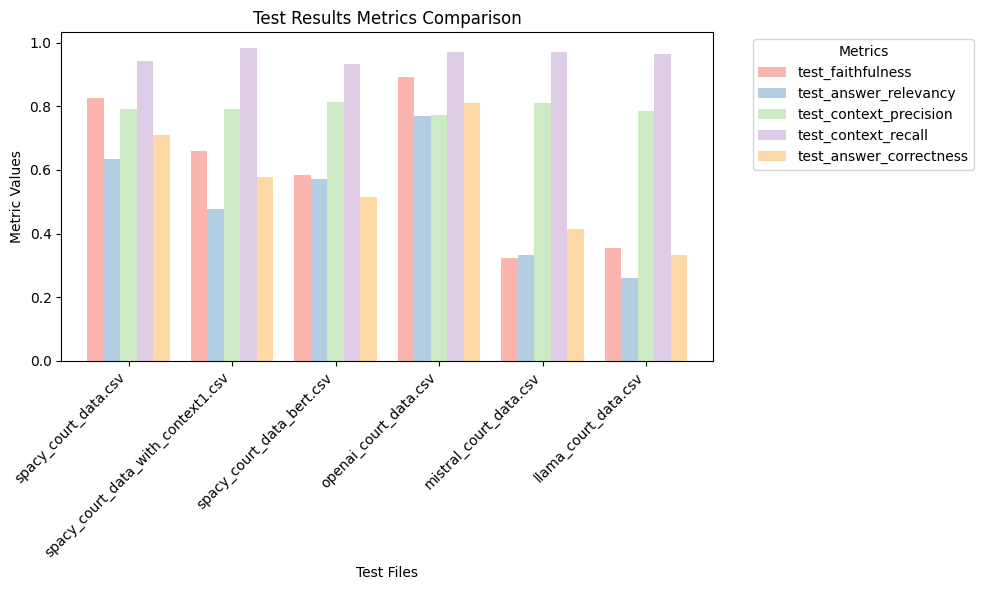

In [61]:
import os
import pandas as pd
import matplotlib.pyplot as plt

test_results_dir = './test_results'

metrics = ['test_faithfulness', 'test_answer_relevancy', 'test_context_precision', 'test_context_recall', 'test_answer_correctness']
data = {metric: [] for metric in metrics}
labels = []

for filename in os.listdir(test_results_dir):
    if filename.endswith('.csv') and not filename.endswith('references_court_data.csv'):
        file_path = os.path.join(test_results_dir, filename)
        df = pd.read_csv(file_path)
        for metric in metrics:
            data[metric].append(df[metric].mean()) 
        labels.append(filename)

aggregated_data = pd.DataFrame(data, index=labels)

ax = aggregated_data.plot(kind='bar', figsize=(10, 6), width=0.8, color=plt.cm.Pastel1.colors)
ax.set_title('Test Results Metrics Comparison')
ax.set_xlabel('Test Files')
ax.set_ylabel('Metric Values')
ax.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [54]:
aggregated_data

,test_faithfulness,test_answer_relevancy,test_context_precision,test_context_recall,test_answer_correctness
spacy_court_data.csv,0.825038,0.634746,0.792708,0.941667,0.708582
spacy_court_data_with_context1.csv,0.658715,0.478700,0.792708,0.983333,0.577041
spacy_court_data_bert.csv,0.582619,0.570593,0.813542,0.933333,0.514284
openai_court_data.csv,0.892810,0.769609,0.772694,0.971667,0.810709
mistral_court_data.csv,0.321894,0.334140,0.808944,0.970000,0.414264
llama_court_data.csv,0.354518,0.261337,0.786611,0.965000,0.332513


In [64]:
new_column_names = {
    'test_faithfulness': 'Faithfulness',
    'test_answer_relevancy': 'Answer Relevancy',
    'test_context_precision': 'Context Precision',
    'test_context_recall': 'Context Recall',
    'test_answer_correctness': 'Answer Correctness'
}

new_index_names = {
    "spacy_court_data.csv" : "SPACY NER",
    "spacy_court_data_with_context1.csv" : "Context-aware masking",
    "openai_court_data.csv" : "GPT-4o",
    "mistral_court_data.csv" : "MISTRAL",
    "llama_court_data.csv" : "LLAMA3.2",
    "spacy_court_data_bert.csv": "BERT NER"
}

aggregated_data = aggregated_data.rename(columns=new_column_names)
aggregated_data = aggregated_data.rename(index=new_index_names)
aggregated_data = aggregated_data.sort_values(by='Answer Correctness', ascending=False)
print(aggregated_data)


                       Faithfulness  Answer Relevancy  Context Precision  \
GPT-4o                     0.892810          0.769609           0.772694   
SPACY NER                  0.825038          0.634746           0.792708   
Context-aware masking      0.658715          0.478700           0.792708   
BERT NER                   0.582619          0.570593           0.813542   
MISTRAL                    0.321894          0.334140           0.808944   
LLAMA3.2                   0.354518          0.261337           0.786611   

                       Context Recall  Answer Correctness  
GPT-4o                       0.971667            0.810709  
SPACY NER                    0.941667            0.708582  
Context-aware masking        0.983333            0.577041  
BERT NER                     0.933333            0.514284  
MISTRAL                      0.970000            0.414264  
LLAMA3.2                     0.965000            0.332513  


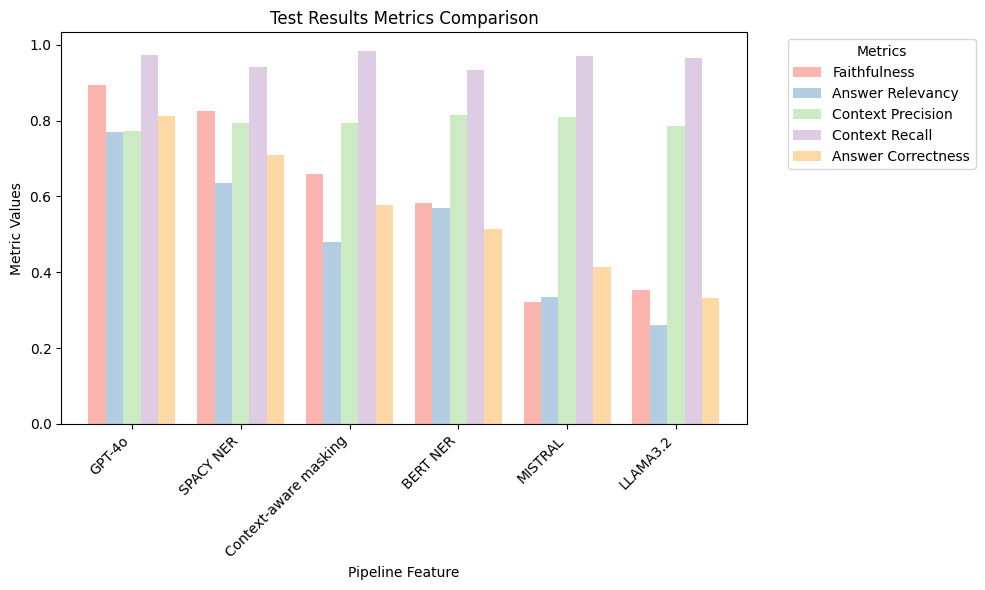

In [65]:
ax = aggregated_data.plot(kind='bar', figsize=(10, 6), width=0.8, color=plt.cm.Pastel1.colors)
ax.set_title('Test Results Metrics Comparison')
ax.set_xlabel('Pipeline Feature')
ax.set_ylabel('Metric Values')
ax.legend(title='Metrics', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()